# Credit Spread Analysis

**What are Credit Spreads?** 

A credit spread is usually defined as the difference between a government bond (e.g., Treasury bonds) and a corporate bond of the same maturity [(Investopedia)](https://www.investopedia.com/terms/c/creditspread.asp#toc-what-is-a-credit-spread). It represents the markets perception of the credit risk associated with the issuer or sector. More specifically, the credit spread can reflect the additional yield investors demand for taking on credit risk relative to a risk-free benchmark. 

A *'wide'* credit spread (a larger difference) indicates that the market perceives higher risk,  typically associated with a greater chance of default, and therefore demands a higher compensation for that potential risk. While a *'narrow'* spread (a small difference) suggests lower perceived risk and greater confidence in the issuers ability to meet its obligations.

Credit spread is calculated as:
$$
\text{Credit Spread} = \text{Yield of Corporate Bond} - \text{Yield of Government Bond}
$$

Example:
- Government X Bond = 5% yield
- Corporate Y Bond = 7% yield 

$$
\text{Spread} = 7\% - 5\% = 2\% \Longrightarrow 200\text{ bps}
$$

**Project Objective**

Credit spreads are influenced by a wide range of factors. These include firm-specific elements such as: financial health, cash flows, and equity performance, as well as broader macroeconomic and market-wide conditions, such as: economic growth, unemployment, monetary policy, and periods of systemic stress (e.g., the 2008 financial crisis). Together, these factors shape how investors assess credit risk and price it in the market.

The objective of this project is to analyse how macroeconomic and market-based factors influence movements in credit spreads, and explore whether these relationships can be captured using a simple Linear Regression model. Focusing on finding and understanding which factors tend to drive spread behaviour across different market regimes. 

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from dotenv import load_dotenv
from fredapi import Fred
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

load_dotenv()
api_key = os.getenv('FRED_API_KEY')

# api error message
if not api_key:
    raise ValueError('FRED_API_KEY not found! Add it to a .env file or set it as an environment variable.')

fred = Fred(api_key=api_key)

## Dataset Construction

In order to conduct this analysis both macroeconomic factors and market-based sentiment need to be considered. By combining these two perspectives, we can observe how the broader economy behaves (e.g., changes in unemployment rates or interest rates) alongside how market investors are reacting; e.g., expectations around returns and overall market volatility.

The features used in this dataset are grouped as the following:
- **Target Variable: Spread**
    - `BAA10YM`: Moody's BAA-rated corporate bond yield spread

- **Macroeconomic Factors**
    - `UNRATE`: Unemployment rate
    - `FEDFUNDS`: Policy interest rate
    - `T10Y2YM`: Yield curve slope (10Y - 2Y)
    - `INDPRO`: Industrial production index
    - `CPIAUCSL`: Inflation (Consumer price index)

- **Market-Based Factors**
    - `VIX`: Market-implied volatility
    - `GSPC`: S&P 500 equity market returns

While the analysis focuses on the period from 2000 - 2025 (end), data is extracted starting from 1999. This is done to support feature engineering steps such as year-over-year transformations, which require earlier observations.

In [2]:
# exctration period
start_date = '1999-01-01'
end_date = '2025-12-01'

# FRED features 
spread = fred.get_series('BAA10YM', observation_start=start_date, observation_end=end_date)
unrate = fred.get_series('UNRATE', observation_start=start_date, observation_end=end_date)
fedfunds = fred.get_series('FEDFUNDS', observation_start=start_date, observation_end=end_date)
yield_curve = fred.get_series('T10Y2YM', observation_start=start_date, observation_end=end_date)
production = fred.get_series('INDPRO', observation_start=start_date, observation_end=end_date)
inflation = fred.get_series('CPIAUCSL', observation_start=start_date, observation_end=end_date)

# yfinance features
vix = yf.download('^VIX', start=start_date, end=end_date)['Close']
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']

C:\Users\touns\AppData\Local\Temp\ipykernel_17064\2230463186.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\touns\AppData\Local\Temp\ipykernel_17064\2230463186.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


In [3]:
# contruct dataframe
df = pd.DataFrame({
    'spread': spread,
    'unrate': unrate,
    'fedfunds': fedfunds,
    'yield_curve': yield_curve,
    'production': production,
    'inflation': inflation,
    'vix': vix['^VIX'],
    'sp500': sp500['^GSPC']
})

df.head(10)

,spread,unrate,fedfunds,yield_curve,production,inflation,vix,sp500
1999-01-01,2.57,4.3,4.63,0.1,87.4949,164.7,NaN,NaN
1999-01-04,NaN,NaN,NaN,NaN,NaN,NaN,26.170000,1228.099976
1999-01-05,NaN,NaN,NaN,NaN,NaN,NaN,24.459999,1244.780029
1999-01-06,NaN,NaN,NaN,NaN,NaN,NaN,23.340000,1272.339966
1999-01-07,NaN,NaN,NaN,NaN,NaN,NaN,24.370001,1269.729980
1999-01-08,NaN,NaN,NaN,NaN,NaN,NaN,23.280001,1275.089966
1999-01-11,NaN,NaN,NaN,NaN,NaN,NaN,25.459999,1263.880005
1999-01-12,NaN,NaN,NaN,NaN,NaN,NaN,28.100000,1239.510010
1999-01-13,NaN,NaN,NaN,NaN,NaN,NaN,30.110001,1234.400024
1999-01-14,NaN,NaN,NaN,NaN,NaN,NaN,32.980000,1212.189941


In [4]:
df.isnull().sum()

spread         6561
unrate         6562
fedfunds       6561
yield_curve    6561
production     6562
inflation      6562
vix             116
sp500           116
dtype: int64

At this stage the dataset contains a mixture of monthly and daily frequencies. This discrepancy mainly arises from the nature of the data sources: most macroeconomic indicators (e.g., unemployment rate, industrial production, inflation, etc.) are reported on a monthly frequency, while market-based data such as VIX and S&P 500 prices are recorded daily. 

Having mixed frequencies makes it difficult to analyse relationships between features consistently. To address this, a common frequency is required. So a strategy is needed to turn daily market variables into monthly frequency so they align with the macroeconomic data and credit spreads. 

**Strategy:**

**VIX:** This feature will be resampled into a monthly frequency, with the monthly value represented by the *mean*. Using the mean provides a better representation of overall maker sentiment during the month. While using the maximum value could capture extreme fear, a single volatility spike does not necessarily reflect the overall sentiment of the month. One highly stressed day does not define the sentiment of the entire month.  

**S&P 500 Returns:** For credit spreads, the actual value of equity prices are less informative than the changes in its value. Equity returns can act as an early warning signal for risk, often reacting before credit markets. Monthly S&P 500 values are therefore constructed using compounded daily returns within each month; allowing the series to capture cumulative equity market movements rather than daily fluctuations. 

In [5]:
# turn vix to monthly using the months average vix
df['vix_monthly'] = df['vix'].resample('MS').mean()

# turn s&p returns to monthly 
df['sp500_pct'] = df['sp500'].pct_change(fill_method=None)
df['sp500_monthly'] = df['sp500_pct'].resample('MS').apply(lambda x: (1 + x).prod() - 1)

df[['vix_monthly', 'sp500_monthly']].head()

,vix_monthly,sp500_monthly
1999-01-01,28.035263,0.041967
1999-01-04,NaN,NaN
1999-01-05,NaN,NaN
1999-01-06,NaN,NaN
1999-01-07,NaN,NaN


In [6]:
df.head()

,spread,unrate,fedfunds,yield_curve,production,inflation,vix,sp500,vix_monthly,sp500_pct,sp500_monthly
1999-01-01,2.57,4.3,4.63,0.1,87.4949,164.7,NaN,NaN,28.035263,NaN,0.041967
1999-01-04,NaN,NaN,NaN,NaN,NaN,NaN,26.170000,1228.099976,NaN,NaN,NaN
1999-01-05,NaN,NaN,NaN,NaN,NaN,NaN,24.459999,1244.780029,NaN,0.013582,NaN
1999-01-06,NaN,NaN,NaN,NaN,NaN,NaN,23.340000,1272.339966,NaN,0.022140,NaN
1999-01-07,NaN,NaN,NaN,NaN,NaN,NaN,24.370001,1269.729980,NaN,-0.002051,NaN


In [7]:
# drop old vix and s&p 500 columns
df = df.drop(columns=['vix', 'sp500', 'sp500_pct'])

# resample dataset to monthly frequency
df = df.asfreq('MS')
df.head()

,spread,unrate,fedfunds,yield_curve,production,inflation,vix_monthly,sp500_monthly
1999-01-01,2.57,4.3,4.63,0.10,87.4949,164.7,28.035263,0.041967
1999-02-01,2.39,4.4,4.76,0.12,88.0270,164.7,28.822632,-0.032283
1999-03-01,2.30,4.2,4.81,0.18,88.2267,164.8,25.309565,0.038794
1999-04-01,2.30,4.3,4.74,0.20,88.4295,165.9,23.478571,0.037944
1999-05-01,2.18,4.2,4.74,0.29,88.9886,166.0,26.204500,-0.038970


In [8]:
df.isnull().sum()

spread           0
unrate           1
fedfunds         0
yield_curve      0
production       1
inflation        1
vix_monthly      1
sp500_monthly    0
dtype: int64

In [9]:
df = df.dropna()

To ensure the model is able to better capture how macroeconomic and market factors influence credit spreads, additionally feature engineering is needed. In some cases, new feature are introduced, while in others, existing variables are transformed or replaced. The goal is to ensure the model focuses on the information that is most relevant to spread movements, rather than learning patterns that are purely mechanical or uninformative.

**Strategy:**

`vix`: As VIX reflects investor fear and perceived market risk, a lagged version of the feature is needed. This allows the model to capture delayed responses in credit markets.

`fedfunds`: In addition to the level of the policy interest rate, a new feature will be created, representing the monthly change in interest rate. This helps distinguish between the overall policy stance and short-term policy adjustments.

`production` & `inflation`: Both industrial production and inflation will be transformed into year-on-year (YoY) changes. These variables are naturally trending over time, and using their raw values may cause the model to learn that loan-term growth pattern, rather than their economical signals. By focusing on YoY changes, the model will instead capture whether these indicators are accelerating or slowing, which is more relevant for understanding changes in credit spread.

In [10]:
# vix lag
df['vix_lag1'] = df['vix_monthly'].shift(1)

# changes in policy interest rates (fedfunds)
df['fedfunds_delta'] = df['fedfunds'] - df['fedfunds'].shift(1)

df[['vix_monthly', 'vix_lag1', 'fedfunds', 'fedfunds_delta']].head()

,vix_monthly,vix_lag1,fedfunds,fedfunds_delta
1999-01-01,28.035263,NaN,4.63,NaN
1999-02-01,28.822632,28.035263,4.76,0.13
1999-03-01,25.309565,28.822632,4.81,0.05
1999-04-01,23.478571,25.309565,4.74,-0.07
1999-05-01,26.204500,23.478571,4.74,0.00


In [11]:
# inflation YoY changes
df['inflation_yoy'] = (df['inflation'] - df['inflation'].shift(12)) / df['inflation'].shift(12)
# production rate yoy changes
df['production_yoy'] = (df['production'] - df['production'].shift(12) / df['production'].shift(12))

# drop raw version of production & inflation 
df = df.drop(columns=['inflation', 'production'])
df = df.dropna()

df.head()

,spread,unrate,fedfunds,yield_curve,vix_monthly,sp500_monthly,vix_lag1,fedfunds_delta,inflation_yoy,production_yoy
2000-01-01,1.67,4.0,5.45,0.22,23.202000,-0.041753,22.159091,0.15,0.027930,90.5380
2000-02-01,1.77,4.1,5.73,-0.09,23.595500,-0.020108,23.202000,0.28,0.032180,90.8239
2000-03-01,2.11,4.0,5.85,-0.27,22.718261,0.096720,23.595500,0.12,0.037621,91.1504
2000-04-01,2.41,3.8,6.02,-0.41,27.164211,-0.035552,22.718261,0.17,0.030139,91.6989
2000-05-01,2.46,4.0,6.27,-0.37,26.373182,-0.021915,27.164211,0.25,0.031325,91.9499


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 310 entries, 2000-01-01 to 2025-11-01
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spread          310 non-null    float64
 1   unrate          310 non-null    float64
 2   fedfunds        310 non-null    float64
 3   yield_curve     310 non-null    float64
 4   vix_monthly     310 non-null    float64
 5   sp500_monthly   310 non-null    float64
 6   vix_lag1        310 non-null    float64
 7   fedfunds_delta  310 non-null    float64
 8   inflation_yoy   310 non-null    float64
 9   production_yoy  310 non-null    float64
dtypes: float64(10)
memory usage: 26.6 KB


In [13]:
df.describe()

,spread,unrate,fedfunds,yield_curve,vix_monthly,sp500_monthly,vix_lag1,fedfunds_delta,inflation_yoy,production_yoy
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,2.476516,5.648387,1.995548,1.065290,19.858184,0.005645,19.865458,-0.004581,0.025839,96.208033
std,0.739880,1.946413,2.032595,0.972777,7.983054,0.044930,7.984123,0.183546,0.017358,4.733268
min,1.410000,3.400000,0.050000,-0.930000,10.125455,-0.169425,10.125455,-0.960000,-0.019588,83.561900
25%,1.920000,4.200000,0.150000,0.220000,14.201071,-0.019783,14.201071,-0.010000,0.016414,91.963300
50%,2.340000,5.000000,1.260000,1.060000,17.796220,0.010713,17.796220,0.000000,0.023375,97.870050
75%,2.887500,6.275000,3.962500,1.885000,23.196750,0.032526,23.196750,0.027500,0.033117,99.955075
max,6.010000,14.800000,6.540000,2.830000,62.639473,0.140162,62.639473,0.700000,0.089993,103.100400


In [14]:
# save dataset
df.to_csv('data/credit_spread.csv')

## Credit Spread Exploratory Analysis

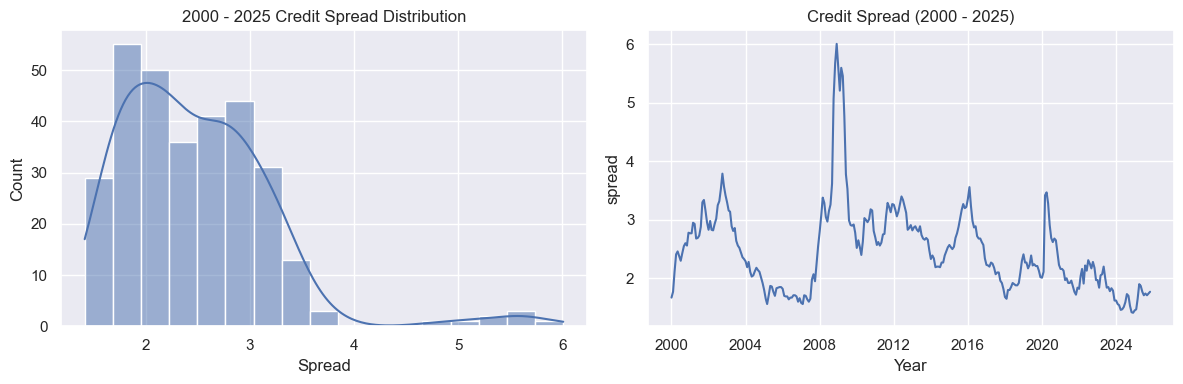

In [15]:
# credit spread overview
sns.set_theme()
plt.figure(figsize=(12, 4))

# spread value distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='spread', kde=True)
plt.title('2000 - 2025 Credit Spread Distribution')
plt.xlabel('Spread')

# spread movement
plt.subplot(1, 2, 2)
sns.lineplot(df['spread'])
plt.title('Credit Spread (2000 - 2025)')
plt.xlabel('Year')

plt.tight_layout()
plt.show()

**Observations**

Looking at how credit spreads moved between 2000 and 2025, there are four clear periods where spreads widened significantly, with peaks exceeding 3.5. These occur in the early 2000's, 2008, 2016 and 2020. Interestingly, each of these periods align with major real-world events that likely contributed to increased market uncertainty and perceived credit risk.  

- **Early 2000s**: [Dot-Com bubble](https://www.investopedia.com/timeline-of-stock-market-crashes-5217820#toc-dotcom-bubble)
- **2008**: [2008 Financial Crisis/ Recesision](https://www.investopedia.com/articles/economics/09/financial-crisis-review.asp)
- **2016**: [U.S. election](https://en.wikipedia.org/wiki/2016_United_States_presidential_election), [Brexit](https://www.bbc.co.uk/news/politics/eu_referendum/results), [Gas markets drop](https://www.eia.gov/todayinenergy/detail.php?id=29552)
- **2020**: [COVID-19](https://en.wikipedia.org/wiki/COVID-19)

These observations suggest that credit spreads are *not* driven only by firm-level or monetary factors.  Suggesting that broader economic conditions, political uncertainty, and systemic shocks also play a role in shaping how credit risk is priced across markets.

In [16]:
df[['spread']].describe()

,spread
count,310.000000
mean,2.476516
std,0.739880
min,1.410000
25%,1.920000
50%,2.340000
75%,2.887500
max,6.010000


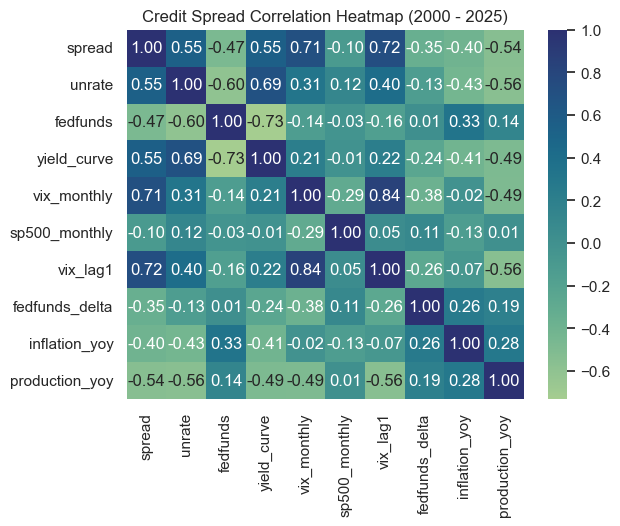

In [17]:
# correlation overview
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='crest')
plt.title('Credit Spread Correlation Heatmap (2000 - 2025)')
plt.show()

**Observations**

The correlation heatmap provides some intersting insights into how some the selected features relate to credit spreads. As expected `vix_monthly` (+0.71) and `unrate` (+0.55) show a positive correlation with spreads. As VIX captures market volitility and investor fear when uncertainty increases, credit spreads tend to widen. Similarly, rising unemployment rates reflect economic weakness, which increases perceived credit risk and is therefore associated with wider spreads.

This realtionship is supoorted by `production_yoy`, which demonstrates a negative correlations with spread (-0.54). This links to the idea that declining economic activity adn reduced production often coincde with her unemployment and increase credit risk, leading to wider spreads.  

The `yield_curve` however, shows a relativly strong positive correlation with spreads (+0.55). The yield curve is known to behave different across market regimes. Periods of the curve flattening or inversion, often associate with credit risk rising and spreads widening; however the correlation score suggests otherwise.  

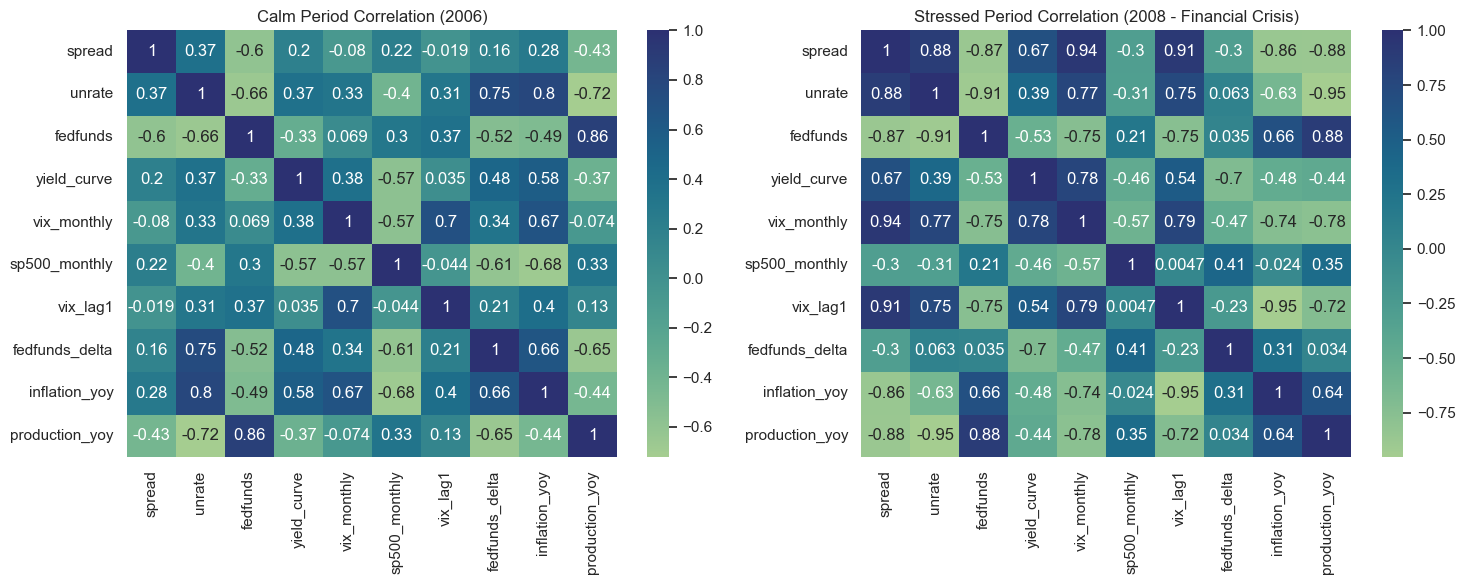

In [18]:
calm_year = df.loc['2006']
stressed_year = df.loc['2008']

plt.figure(figsize=(15, 6))

# calm period
plt.subplot(1, 2, 1)
sns.heatmap(calm_year.corr(), annot=True, cmap='crest')
plt.title('Calm Period Correlation (2006)')

# stressed period
plt.subplot(1, 2, 2)
sns.heatmap(stressed_year.corr(), annot=True, cmap='crest')
plt.title('Stressed Period Correlation (2008 - Financial Crisis)')

plt.tight_layout()
plt.show()

**Observations**

When comparing correlation across different periods, a clear difference emerge in how these factors behave under different market regimes. During stressed/ high-risk periods, correlations become noticeably stronger when compared to calmer periods; where correlations between features and spreads are generally weaker.

Calm period:

During a calm period, correlations are relatively low across the board. The strongest relationship observed is with `fedfunds`, which shows a correlation of -0.60. Suggesting that during stable market conditions, monetary policy and interest rate levels play a more significant role in explaining credit spread behaviour compared to other factors.

Other factors such as `unrate`, `infaltion_yoy` and `production_yoy` also display moderately strong correlations with spread (above ±0.25). Together, these relationships suggest that during calm periods, spreads are more closely linked to broader macroeconomic conditions and policy stance, reflecting a relatively stable and progressive economic environment.

Stress period:

In contrast, during a stress period such as the 2008 financial crisis, correlations strengthen significantly. Most features, excluding `fedfunds_delta` and `sp500_monthly`, demonstrate exceedingly high correlations (±0.65). In particular, `unrate`, `vix_monthly` and `vix_lag1` all show very strong positive correlations with spreads (above +0.85), highlighting the dominant role of labour market deterioration and market volatility during periods of extreme stress.

These three variables also display strong correlation with each other (ranging from +0.75 to +0.77), suggesting that during stress regimes, market fear, economic weakness, and credit risk become tightly linked and tend to move together.

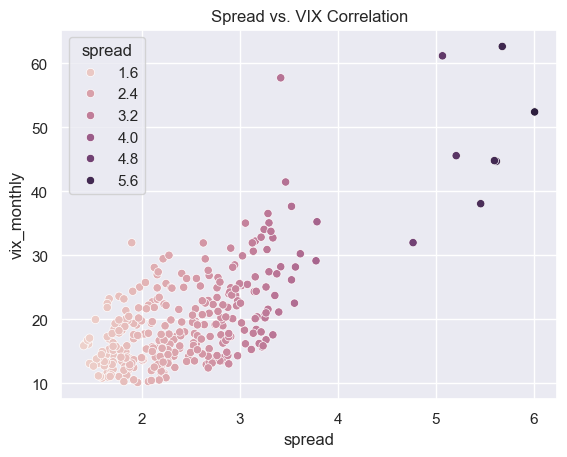

In [19]:
# spread vs VIX
sns.scatterplot(data=df, x='spread', y='vix_monthly', hue='spread')
plt.title('Spread vs. VIX Correlation')
plt.show()

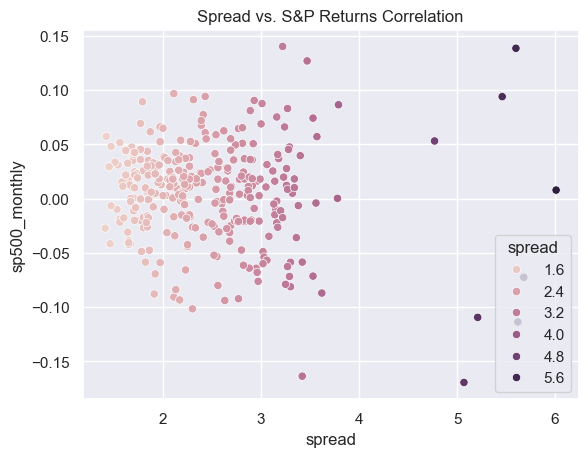

In [20]:
# spread vs s&p
sns.scatterplot(data=df, x='spread', y='sp500_monthly', hue='spread')
plt.title('Spread vs. S&P Returns Correlation')
plt.show()


## Modelling: Linear Regression

Given the continous nature of credit spreads and the objective of this project, a simple linear regression model is chosen. As the priamry goal is to identify and understanding the main drivers of credit spreads, linear regression is well suited for such tasks. 

Through its 'best-fit line' and coefficient estimates, the model provides an interpretable way to assess both the direction and relative influence of each factor on spread movemetns, allowing for a clearer udnderstading of how these different macroeconomic and market-based variables contribute to changes in credit spreads.   

### Data Preprocessing

In [21]:
# train & test splits 
train = df.loc['2000': '2015']
test = df.loc['2016':'2017']

# training set
X_train = train.drop(columns='spread')
y_train = train['spread']

# testing set
X_test = test.drop(columns='spread')
y_test = test['spread'] 

# size check
print(f'Training-set size: {X_train.shape[0]} rows')
print(f'Testing-set size: {X_test.shape[0]} rows')

Training-set size: 192 rows
Testing-set size: 24 rows


In order to properly compare the coefficients of each driver, the dataset needs to be standardised. This is due to the different scales and ranges across features. By standardising the dataset, each variable is placed on a similar scale, allowing the resulting coefficients to be meaningfully compared and interpreted on a more level playing field.

In [22]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Cross-validation

In [23]:
# linear regression model
model = LinearRegression()

# cross-validate using timeseriessplit
tscv = TimeSeriesSplit(n_splits=10)
cv = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_results = -cv

print(cv_results)
print(f'Cross-validation average RMSE: {cv_results.mean():.3f}')

[0.73061882 0.44919052 0.17959679 0.18502925 0.57891976 1.09747155
 0.38065933 0.43965352 0.24188745 0.27436234]
Cross-validation average RMSE: 0.456


### Model Training

In [24]:
# train model
model.fit(X_train_scaled, y_train)

# coefficients
model.coef_

array([ 0.00521504, -0.58425   , -0.36400832,  0.26683009, -0.01318236,
        0.31251665, -0.14662844, -0.04931726, -0.07574124])

In [25]:
# coefficient mapping
coef_df = pd.DataFrame({
    'features': X_train.columns,
    'coefficient': model.coef_,
    'coef_abs': abs(model.coef_) # highlght magnitude of coefficients
})
# descending order
coef_df = coef_df.sort_values('coef_abs', ascending=False, ignore_index=True)

coef_df

,features,coefficient,coef_abs
0,fedfunds,-0.584250,0.584250
1,yield_curve,-0.364008,0.364008
2,vix_lag1,0.312517,0.312517
3,vix_monthly,0.266830,0.266830
4,fedfunds_delta,-0.146628,0.146628
5,production_yoy,-0.075741,0.075741
6,inflation_yoy,-0.049317,0.049317
7,sp500_monthly,-0.013182,0.013182
8,unrate,0.005215,0.005215


**Findings**

Strongest Drivers:

- `fedfunds`
    - Showing the strongest coefficient (-0.58), policy interest rates emerge as the most influential driver in the model. Historically, higher interest rates have tended to coincide with growth signals rather than periods of stress, during which credit spreads are typically narrower. This reflects historical co-movement observed in the data rather than a causal relationship.  
- `yield_curve`
    - As expected, the yield curve shows a strong negative coefficient (-0.36). A flatter or inverted curve signals increased expectations of future stress and is typically associated with wider spreads, while steeper curves reflect more optimistic growth expectations and narrower spreads. This observation goes against the positive correlation we observed in the earlier correlation heatmap.
- `vix_monthly` & `vix_lag1`
    - Both volatility measures carry positive coefficients (+0.27 and +0.31 respectively), indicating that higher market volatility tends to coincide with wider credit spreads. This suggests that credit markets respond more strongly to sustained periods of volatility rather than one-off isolated spikes.
- `fedfunds_delta`
    - Reinforcing the results from `fedfunds`, changes in interest rates show a smaller negative coefficient (-0.15). Indicating that while the overall policy stance matters, short term rate changes historically played a more limited role in explaining spread movements. As before, these findings reflect historical regimes rather than policy mechanics.

Secondary Drivers:

`production_yoy` and `inflation_yoy` show relatively small coefficients (-0.07 and -0.05 respectively), suggesting that real-economy fundamentals have a weaker influence on spreads compared to financial and policy related factors. 

Equity Market Signals:

Interestingly, `sp500_monthly` carries a very small coefficient (-0.01), suggesting that equity returns provide limited explanatory power at a monthly frequency. This indicates that by the time monthly equity returns are observed, most risk-signals that they would provide is already captured by variables such as market volatility, yield curve and policy interest rates.

### Model Test

In [26]:
# predictions
y_pred = model.predict(X_test_scaled)

In [27]:
# model evaluation
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) 

print(f'RMSE Score: {rmse:.3f}')
print(f'MAE Score: {mae:.3f}')
print(f'R2 Score: {r2:.3f}')

RMSE Score: 0.238
MAE Score: 0.205
R2 Score: 0.736


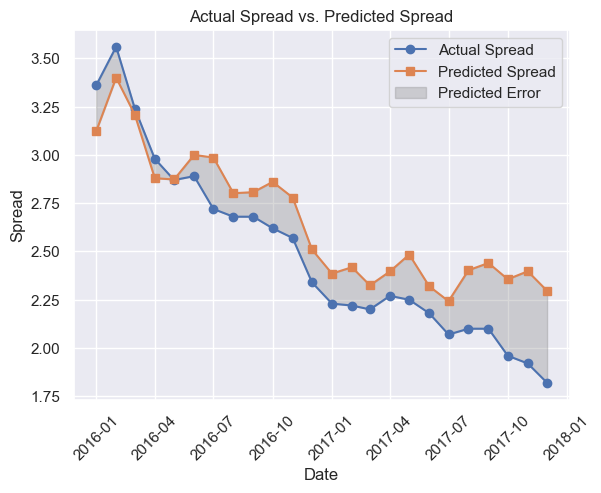

In [28]:
# model predictions plot against actuals
plt.plot(y_test.index, y_test, marker='o', label='Actual Spread')
plt.plot(y_test.index, y_pred, marker='s',label='Predicted Spread')
plt.fill_between(y_test.index, y_test, y_pred, color='grey', alpha=0.3, label='Predicted Error')
plt.title('Actual Spread vs. Predicted Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Findings**

From the predicted vs actual spreads plot, alongside error values of ~0.2, we can see that the model trained on data from 2000 to 2015 performs reasonably well when predicting spreads during the 2016/17 period. Overall, predictions remain fairly consistent with the observed spread movement across most of the testing window. 

The predicted vs actual spreads plot shows that predictions errors begin to gradually increase towards the end of the testing period, particularly during 2017. This behaviour is to be expected, as the further the test period moves away from the training window, the more likely it is that relationships learned by the model begin to weaken, leading to increased prediction errors.  

During this regime, the model achieves an R² score of ~0.74, indicating that around 74% of the variation in credit spreads is explained by the features in this projects dataset. This suggests that the selected macroeconomic and market-based variables are effective at capturing spread dynamics during relatively stable market conditions. However, it is important to note that this evaluation is conducted during a calm period, which likely contributes to the models stable behaviour and strong performance.

## Coefficient Comparison: Calm vs. Stressed Regime

Previously, correlations heatmaps were comapred fro a calm period (2006) and during the [2008 financial crisis](https://www.investopedia.com/articles/economics/09/financial-crisis-review.asp), revelaing a clear difference in how macroeconomic and market based factors relate to credit spreads under different levels of financial stress.

To explore this realisation further, two additional linear regression models will be built: one trained during a calm period (2005 - 2006), and one trained during a stressed period (2008 - 2009). By comparing the coefficients from each model, we can observe how the influence of the different features changes across regimes, and how well each factor helps in explaining credit spread behaviour during calm and stressed conditions.

In [29]:
# models
calm_model = LinearRegression()
stressed_model = LinearRegression()

# calm and stressed samples
calm_period = df.loc['2005': '2006']
stressed_period = df.loc['2008': '2009']

# calm sample splitting
X_train_calm = calm_period.drop(columns='spread') 
y_train_calm = calm_period['spread']

# stressed sample splitting
X_train_stressed = stressed_period.drop(columns='spread')
y_train_stressed = stressed_period['spread']

In [30]:
# scale calm & stressed samples
X_train_calm_scaled = scaler.fit_transform(X_train_calm)
X_train_stressed_scaled = scaler.fit_transform(X_train_stressed)

### Calm Model Coefficients

In [31]:
# calm period coefficients
calm_model.fit(X_train_calm_scaled, y_train_calm)
calm_coef = calm_model.coef_

# map coefficients to features 
calm_coef_df = pd.DataFrame({
    'feature': X_train_calm.columns,
    'calm_coef': calm_coef,
    'calm_coef_abs': abs(calm_coef)
})

calm_coef_df = calm_coef_df.sort_values('calm_coef_abs', ascending=False, ignore_index=True)

calm_coef_df

,feature,calm_coef,calm_coef_abs
0,fedfunds,-0.131976,0.131976
1,yield_curve,-0.089368,0.089368
2,unrate,-0.060319,0.060319
3,production_yoy,-0.047214,0.047214
4,vix_lag1,0.041396,0.041396
5,vix_monthly,-0.014754,0.014754
6,inflation_yoy,0.012470,0.012470
7,fedfunds_delta,-0.007395,0.007395
8,sp500_monthly,0.005315,0.005315


**Findings:**

During the calm period of 2005 - 2006, coefficient magnitudes are relatively small across the board. This is an expected result and reflects the narrow and stable nature of credit spreads during this period. The outcome also aligns with the earlier correlation analysis, which showed weaker and more stable relationships between features during non-stressed market conditions.

Most Influential Variables:
- `fedfunds`
    - Policy interest rates emerge as the most influential variable, with a coefficient of -0.13. This suggests that higher interest rate levels historically coincided with tighter credit spreads during calm periods.
- `yield_curve`
    - The yield curve also carries a negative coefficient (-0.09), indicating that a steeper curve, reflecting more optimistic expectations about future growth, was associated with narrower spreads. This further supports the idea that both policy stance and forward-looking market expectations helped anchor credit spreads during calm regimes

Interestingly, despite interest rates scoring strongest influence in terms of levels, changes in interest rates (`fedfunds_delta`) displayed minimal coefficients. Implying that month-to-month policy adjustments carried little to no information for credit markets during this period. This likely reflects the predictable and gradual nature of policy changes in calm environments, limiting their impact on perceived credit risk.

### Stressed Model Coefficients

In [32]:
# stressed period coefficients
stressed_model.fit(X_train_stressed_scaled, y_train_stressed)
stressed_coef = stressed_model.coef_

stressed_coef_df = pd.DataFrame({
    'feature': X_train_stressed.columns,
    'stressed_coef': stressed_coef,
    'stressed_coef_abs': abs(stressed_coef)
})

stressed_coef_df = stressed_coef_df.sort_values('stressed_coef_abs', ascending=False, ignore_index=True)

stressed_coef_df

,feature,stressed_coef,stressed_coef_abs
0,production_yoy,-0.995122,0.995122
1,unrate,-0.758194,0.758194
2,vix_monthly,0.547012,0.547012
3,vix_lag1,0.370795,0.370795
4,yield_curve,-0.221694,0.221694
5,sp500_monthly,0.154875,0.154875
6,inflation_yoy,0.146627,0.146627
7,fedfunds,-0.113592,0.113592
8,fedfunds_delta,-0.011698,0.011698


**Findings:** 

In contrast to the all around low coefficients magnitudes observed during calm regimes, coefficients during a stressed period, such as the 2008 financial crisis, are significantly larger across most variables. This reinforces the earlier correlations analysis, which showed that relationships between credit spreads and their drivers become much more stronger during periods of heightened financial stress.

While all factors demonstrate strong coefficients, the most influential drives during this period are:
- `production_yoy`
    - Industrial production emerges as the strongest driver, with a coefficient of -0.995. This suggests that declining production levels are closely associated with widening credit spreads. Historically, this aligns with the 2008 financial crisis, during which widespread business slowdowns and shutdowns led to the economy being affected negatively.
- `unrate`
    - The unemployment rate is the second strongest driver, with a coefficient of -0.76. This reflects the close link between deteriorating labour market conditions and credit risk during the crisis. As unemployment rose sharply during this period, credit spreads widened alongside broader economic distress.
- `vix_monthly` & `vix_lag1`
    - Both volatility measures carry large positive coefficients (+0.55 and +0.37 respectively), representing a substantial increase compared to their influence during calm periods. This highlights the dominant role of sustained market fear and uncertainty during the financial crisis, where elevated volatility coincided with significantly wider credit spreads.

Interestingly, while policy interest rates (`fedfunds`) were a dominant driver during calm regimes, they exhibit some of the smallest coefficients during the stressed period. This likely reflects the nature of monetary policy during crisis, where interest rates are rapidly reduced in response to deteriorating economic conditions, rather than serving as an independent signal of credit risk [(BBC)](https://www.bbc.co.uk/news/business-11013715).

## Conclusion

In this analysis on credit spread, the following observations were made:
- Found four major periods of significant credit spread widening were identified and mapped to real-world events (e.g. the dot-com crash, the 2008 financial crisis, and COVID-19).
    - Highlighting the role of systemic economic and market stress in spread behaviour. 
- Correlation analysis showed that relationships between credit spreads and macroeconomic variables become significantly stronger during stressed periods when compared to calmer regimes.
- Found that during calm market conditions, policy-related factors such as interest rate levels emerged as the strongest drivers of credit spreads.
    - In contrast, during stressed regimes, spreads were more strongly influenced by macroeconomic deterioration and market sentiment variables, including industrial production, unemployment, and market volatility (VIX).
- A linear regression model trained on data from 2000 to 2015 achieved stable performance when tested on a relatively calm period (2016 – 2017), with an RMSE of 0.238, MAE of 0.205, and an R² score of 0.736.
    - Suggesting that the selected macroeconomic and market-based features are effective at explaining spread dynamics under stable market conditions.

---

In the next part of this project, a stress test will be performed by applying a linear regression model trained on data from 2000 to 2019, tested on the COVID-19 period. This aims to assess how relationships learned from historical regimes behave under extreme & structurally different market stress. 

Click here: [**COVID-19 Stress-test**](covid_case_study.ipynb)